# SumStarAI Reviews - Categorization

This notebook implements the final categorization of products and reviews for the SumStarAI-Reviews project. The goal is to categorize products into 4 main categories to ensure we have enough reviews in each category for generating meaningful recommendations.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_palette('Set2')

## 1. Load and Explore the Dataset

In [2]:
print("Loading dataset...")
# Load the processed data
reviews_df = pd.read_csv('processed_sentiment_amazon_final.csv')
print(f"Dataset shape: {reviews_df.shape}")

# Display the columns to see what we're working with
print(f"Dataset columns: {reviews_df.columns.tolist()}")

# Show a sample of the data
reviews_df.head()

Loading dataset...
Dataset shape: (28332, 9)
Dataset columns: ['reviews.text', 'cleaned_text', 'name', 'categories', 'sentiment_label', 'sentiment_score', 'reviews.rating', 'rating_sentiment', 'mapped_sentiment']


,reviews.text,cleaned_text,name,categories,sentiment_label,sentiment_score,reviews.rating,rating_sentiment,mapped_sentiment
0,I order 3 of them and one of the item is bad q...,i order 3 of them and one of the item is bad q...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_0,0.902380,3,Neutral,Negative
1,Bulk is always the less expensive way to go fo...,bulk is always the less expensive way to go fo...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_1,0.697489,4,Positive,Neutral
2,Well they are not Duracell but for the price i...,well they are not duracell but for the price i...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.890748,5,Positive,Positive
3,Seem to work as well as name brand batteries a...,seem to work as well as name brand batteries a...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.938524,5,Positive,Positive
4,These batteries are very long lasting the pric...,these batteries are very long lasting the pric...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.965138,5,Positive,Positive


In [3]:
# Create a new dataframe with unique products
product_df = reviews_df.drop_duplicates(subset=['name'])[['name', 'categories']]
print(f"Number of unique products: {len(product_df)}")

# Remove products with missing categories
product_df = product_df.dropna(subset=['categories'])
print(f"Number of products after removing missing categories: {len(product_df)}")

# Display a few products
product_df.head()

Number of unique products: 65
Number of products after removing missing categories: 65


,name,categories
0,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C..."
8343,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"Audio & Video Accessories,TV, Video & Home Aud..."
8347,Amazon Echo âÃÃ¬ White,"Stereos,Remote Controls,Audio Docks & Mini Spe..."
8349,Amazon Echo Show - Black,"Amazon Echo,Virtual Assistant Speakers,Electro..."
8350,Echo Spot Pair Kit (Black),"Amazon Echo,Networking,Home & Tools,Smart Home..."


## 2. Analyze Original Categories

In [4]:
# Analyze all the categories to understand the distribution
all_categories = []
for cat_str in product_df['categories']:
    if isinstance(cat_str, str):
        categories = cat_str.split(',')
        all_categories.extend([cat.strip() for cat in categories])

category_counter = Counter(all_categories)
print(f"Found {len(category_counter)} unique categories")

# Display top categories
print("\nTop 20 Categories:")
for cat, count in category_counter.most_common(20):
    print(f"{cat}: {count}")

Found 314 unique categories

Top 20 Categories:
Electronics: 44
Computers & Tablets: 29
Tablets: 25
Fire Tablets: 20
Amazon Tablets: 20
Electronics Features: 19
All Tablets: 19
Amazon: 14
Computers/Tablets & Networking: 14
Consumer Electronics: 13
Smart Speakers: 12
Computers & Accessories: 10
Amazon Ereaders: 10
Kindle E-readers: 10
Amazon Book Reader: 10
Amazon Echo: 9
Digital Device 3: 9
Amazon Home: 9
E-Readers & Accessories: 9
Accessories: 8


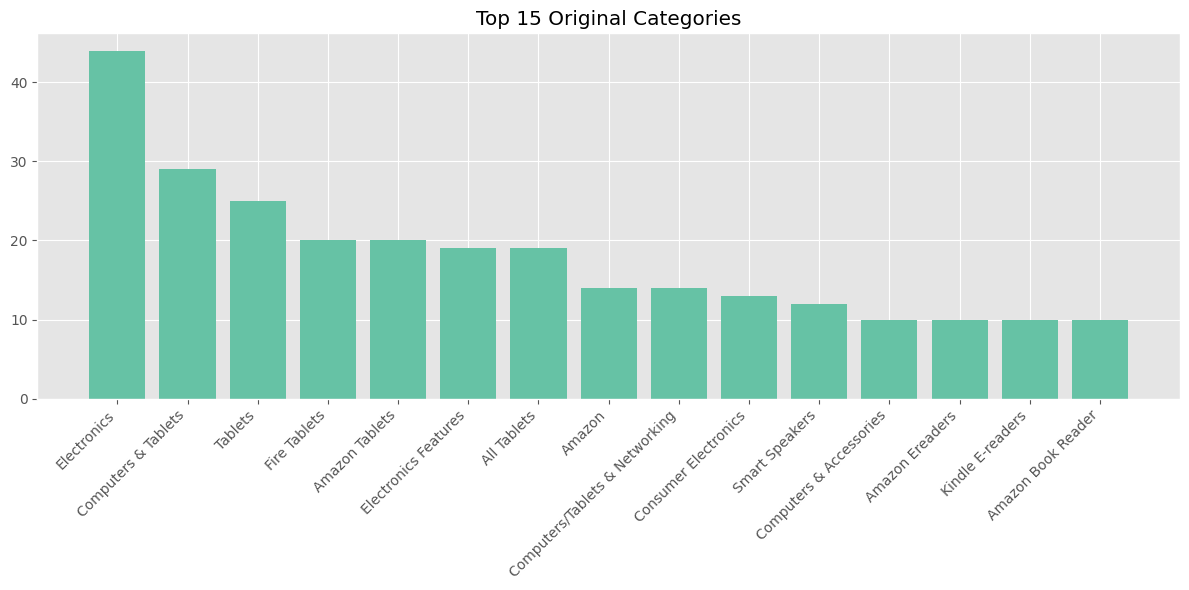

In [5]:
# Visualize top 15 categories
top_categories = dict(category_counter.most_common(15))
plt.figure(figsize=(12, 6))
plt.bar(top_categories.keys(), top_categories.values())
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Original Categories')
plt.tight_layout()
plt.show()

## 3. Define the Improved Categorization Function

We'll define a function to categorize products into 4 main categories:
1. E-readers
2. Smart Home & Speakers
3. Tablets & Entertainment
4. Accessories

In [6]:
def get_category_improved(row):
    """Enhanced function to determine the category for a product based on its name and categories"""
    name = row['name'].lower() if isinstance(row['name'], str) else ""
    categories = row['categories'].lower() if isinstance(row['categories'], str) else ""
    
    # Split categories into a list for easier checking
    category_list = [cat.strip() for cat in categories.split(',')] if isinstance(categories, str) else []
    
    # E-readers category - CHECK FIRST (higher priority)
    # Expanded list of e-reader terms
    ereader_terms = [
        'kindle', 'e-reader', 'ereader', 'oasis', 'paperwhite', 'e-readers', 
        'amazon ereaders', 'amazon book reader', 'kindle e-readers', 'e-reader', 
        'ebook', 'e-book', 'e-ink', 'reader', 'voyage'
    ]
    
    # Check name for direct mentions of Kindle models
    if ('kindle' in name.lower() or 
        any(term in name.lower() for term in ereader_terms) or 
        any(any(term in cat.lower() for term in ereader_terms) for cat in category_list)):
        # Make sure it's not a Kindle accessory
        if not any(acc_term in name.lower() for acc_term in ['case', 'cover', 'sleeve', 'charger', 'adapter', 'cable']):
            return "E-readers"
    
    # Smart Speakers category - check second for priority
    speaker_terms = [
        'echo', 'alexa', 'smart assistant', 'tap', 'dot', 'smart speakers',
        'amazon echo', 'amazon home', 'smart home', 'voice assistant', 'speaker',
        'smart device', 'home assistant', 'smart hub'
    ]
    
    if any(term in name.lower() for term in speaker_terms) or \
       any(any(term in cat.lower() for term in speaker_terms) for cat in category_list):
        # Make sure it's not a speaker accessory
        if not any(acc_term in name.lower() for acc_term in ['case', 'cover', 'sleeve', 'charger', 'adapter', 'cable']):
            return "Smart Home & Speakers"
    
    # Tablets category - check after e-readers and smart speakers
    tablet_terms = [
        'tablet', 'fire hd', 'fire kids', 'amazon tablets', 
        'fire tablets', 'all tablets', 'computers & tablets', 'tablets', 'digital device',
        'fire 7', 'fire 8', 'fire 10'
    ]
    
    # Special case for Fire tablets - they're tablets, not e-readers
    if ('fire tablet' in name.lower() or 'fire hd' in name.lower() or
        any(term in name.lower() for term in tablet_terms) or 
        any(any(term in cat.lower() for term in tablet_terms) for cat in category_list)):
        # Make sure it's not an e-reader misclassified as a tablet
        if not any(ereader in name.lower() for ereader in ['kindle', 'e-reader', 'ereader', 'oasis', 'paperwhite']):
            # Make sure it's not a tablet accessory
            if not any(acc_term in name.lower() for acc_term in ['case', 'cover', 'sleeve', 'charger', 'adapter', 'cable']):
                return "Tablets & Entertainment"
    
    # Entertainment devices (Fire TV, etc.)
    entertainment_terms = [
        'fire tv', 'firetv', 'tv stick', 'streaming', 'media player', 
        'entertainment', 'video', 'movie', 'television'
    ]
    
    if any(term in name.lower() for term in entertainment_terms) or \
       any(any(term in cat.lower() for term in entertainment_terms) for cat in category_list):
        return "Tablets & Entertainment"
    
    # All Accessories (merged category for all accessories)
    accessory_terms = [
        'case', 'cover', 'sleeve', 'charger', 'adapter', 'cable', 'stand',
        'screen protector', 'skin', 'stylus', 'pen', 'keyboard', 'dock',
        'holder', 'mount', 'bag', 'pouch', 'protector', 'battery', 'batteries',
        'usb', 'hdmi', 'computer', 'laptop', 'mouse', 'monitor', 'backpack',
        'storage', 'memory', 'sd card', 'flash drive', 'headphone', 'earphone'
    ]
    
    # Check if it's an accessory for any device or a general accessory
    if (any(acc_term in name.lower() for acc_term in accessory_terms) or
        any(any(acc_term in cat.lower() for acc_term in ['accessories', 'accessory']) for cat in category_list)):
        return "Accessories"
    
    # Electronics (general) - check if it's electronic but doesn't fit above categories
    electronics_terms = [
        'electronics', 'consumer electronics', 'electronics features', 
        'power', 'charging', 'audio', 'video', 'camera'
    ]
    
    if any(term in name.lower() for term in electronics_terms) or \
       any(any(term in cat.lower() for term in electronics_terms) for cat in category_list):
        return "Accessories"
    
    # Default to Other
    return "Other Products"

## 4. Apply the Improved Categorization

In [7]:
# Apply the improved categorization function
product_df['product_category'] = product_df.apply(get_category_improved, axis=1)

# Count products by category
category_counts = product_df['product_category'].value_counts()
print("\nDistribution of products across improved categories:")
for category, count in category_counts.items():
    print(f"{category}: {count} products ({count/len(product_df)*100:.1f}%)")


Distribution of products across improved categories:
Accessories: 20 products (30.8%)
E-readers: 18 products (27.7%)
Smart Home & Speakers: 13 products (20.0%)
Tablets & Entertainment: 11 products (16.9%)
Other Products: 3 products (4.6%)


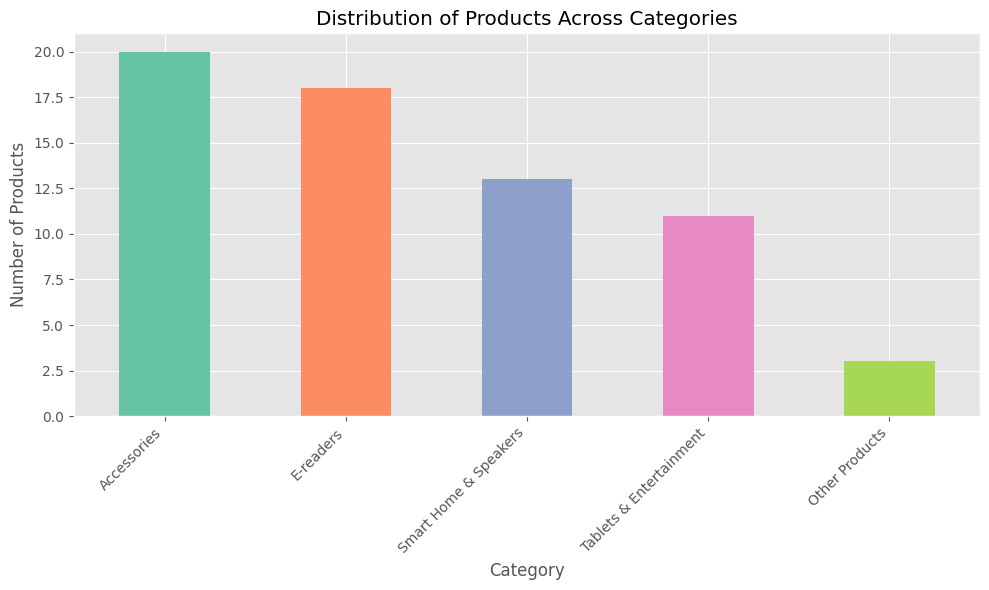

In [8]:
# Visualize the product distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color=sns.color_palette('Set2'))
plt.title('Distribution of Products Across Categories')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Analyze Each Category

In [9]:
# Analyze each category
categories = product_df['product_category'].unique()

for category in sorted(categories):
    print(f"\n### {category} Category Analysis ###")
    
    # Get products in this category
    category_products = product_df[product_df['product_category'] == category]
    print(f"Number of products: {len(category_products)}")
    
    # Find the most common individual categories
    all_cats = []
    for cat_str in category_products['categories']:
        if isinstance(cat_str, str):
            categories = cat_str.split(',')
            all_cats.extend([cat.strip() for cat in categories])
    
    cat_counts = Counter(all_cats)
    print("\nTop 10 individual categories:")
    for cat, count in cat_counts.most_common(10):
        print(f"{cat}: {count}")
    
    # Sample products
    print("\nSample products:")
    sample = category_products.sample(min(5, len(category_products)))
    for _, row in sample.iterrows():
        print(f"- {row['name']}")


### Accessories Category Analysis ###
Number of products: 20

Top 10 individual categories:
Electronics: 11
Accessories: 7
Computers & Accessories: 7
Computers & Tablets: 6
Health: 4
Electronics Features: 4
Computers/Tablets & Networking: 4
Digital Device Accessory: 4
Kitchen: 4
Computer Accessories & Peripherals: 3

Sample products:
- Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers
- AmazonBasics 11.6-Inch Laptop Sleeve
- AmazonBasics USB 3.0 Cable - A-Male to B-Male - 6 Feet (1.8 Meters)
- AmazonBasics Nespresso Pod Storage Drawer - 50 Capsule Capacity
- All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case

### E-readers Category Analysis ###
Number of products: 18

Top 10 individual categories:
Electronics: 15
Computers & Tablets: 14
Tablets: 12
All Tablets: 10
Electronics Features: 8
Computers/Tablets & Networking: 8
Amazon Ereaders: 7
Kindle E-readers: 7
Amazon Book Reader:

## 6. Map Categories to Reviews

In [10]:
# Create a mapping from product name to category
product_to_category = dict(zip(product_df['name'], product_df['product_category']))

# Add category information to the original reviews dataframe
reviews_df = reviews_df.copy()
reviews_df['product_category'] = reviews_df['name'].map(product_to_category)

# Check if any reviews are missing category information
missing_categories = reviews_df['product_category'].isnull().sum()
print(f"\nReviews with missing category information: {missing_categories}")

# Remove reviews with missing category information
categorized_reviews = reviews_df.dropna(subset=['product_category'])
print(f"Reviews dataset shape after removing missing categories: {categorized_reviews.shape}")


Reviews with missing category information: 0
Reviews dataset shape after removing missing categories: (28332, 10)


In [11]:
# Count reviews by category
review_counts = categorized_reviews['product_category'].value_counts()
total_reviews = len(categorized_reviews)

print("\nDistribution of reviews across categories:")
for category, count in review_counts.items():
    print(f"{category}: {count} reviews ({count/total_reviews*100:.1f}%)")


Distribution of reviews across categories:
Accessories: 14093 reviews (49.7%)
E-readers: 6350 reviews (22.4%)
Smart Home & Speakers: 4266 reviews (15.1%)
Tablets & Entertainment: 3619 reviews (12.8%)
Other Products: 4 reviews (0.0%)


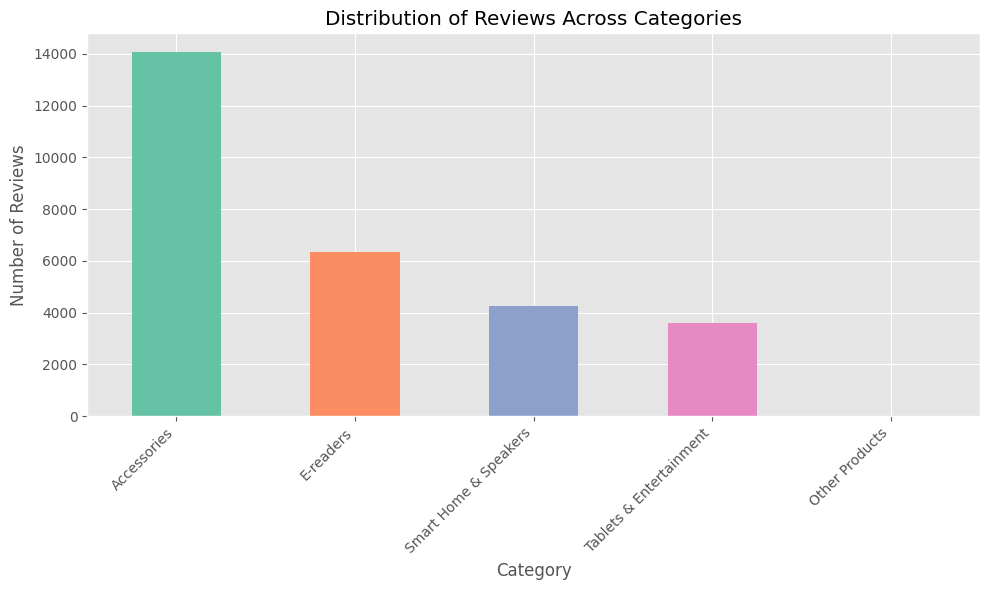

In [12]:
# Visualize the review distribution
plt.figure(figsize=(10, 6))
review_counts.plot(kind='bar', color=sns.color_palette('Set2'))
plt.title('Distribution of Reviews Across Categories')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Consolidate Categories with Few Reviews

In [13]:
# Check if we have enough reviews for each category
MIN_REVIEWS_PER_CATEGORY = 1000  # Minimum threshold for better review generation
categories_with_few_reviews = [cat for cat, count in review_counts.items() if count < MIN_REVIEWS_PER_CATEGORY]

if categories_with_few_reviews:
    print(f"\nWARNING: The following categories have fewer than {MIN_REVIEWS_PER_CATEGORY} reviews:")
    for cat in categories_with_few_reviews:
        print(f"- {cat}: {review_counts[cat]} reviews")
    
    print("\nConsolidating categories with few reviews...")
    
    # Merge categories with few reviews into larger categories
    def consolidate_categories(row):
        if row['product_category'] in categories_with_few_reviews:
            # Merge categories with few reviews into appropriate larger categories
            if row['product_category'] == 'Other Products' or row['product_category'] == 'Electronics & Accessories':
                return "Accessories"
        return row['product_category']
    
    categorized_reviews['product_category'] = categorized_reviews.apply(consolidate_categories, axis=1)
    
    # Update the product categories as well
    product_df['product_category'] = product_df.apply(consolidate_categories, axis=1)
    
    # Recount reviews by category after consolidation
    review_counts = categorized_reviews['product_category'].value_counts()
    print("\nDistribution of reviews across consolidated categories:")
    for category, count in review_counts.items():
        print(f"{category}: {count} reviews ({count/total_reviews*100:.1f}%)")


- Other Products: 4 reviews

Consolidating categories with few reviews...

Distribution of reviews across consolidated categories:
Accessories: 14097 reviews (49.8%)
E-readers: 6350 reviews (22.4%)
Smart Home & Speakers: 4266 reviews (15.1%)
Tablets & Entertainment: 3619 reviews (12.8%)


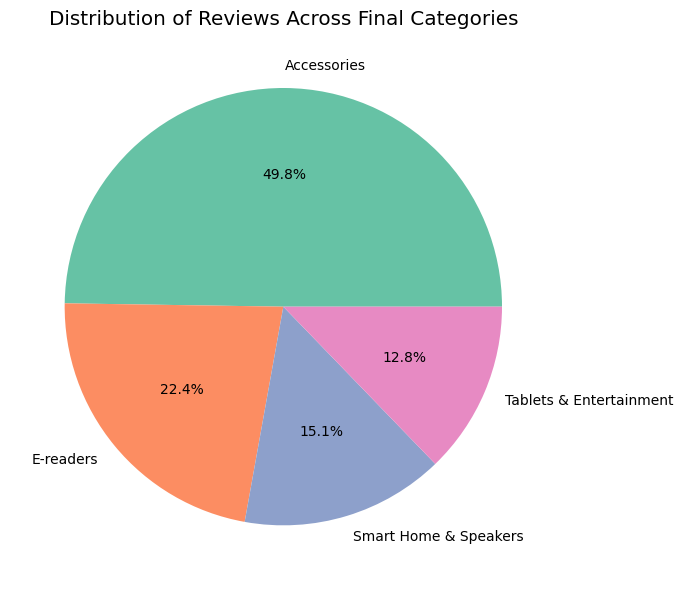

In [14]:
# Visualize the final review distribution after consolidation
plt.figure(figsize=(10, 6))
review_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Distribution of Reviews Across Final Categories')
plt.ylabel('')
plt.tight_layout()
plt.show()

## 8. Create Final Category List and Mapping

In [ ]:
# Create final category list with only categories that have enough reviews
final_categories = [cat for cat, count in review_counts.items() if count >= MIN_REVIEWS_PER_CATEGORY]
print(f"\nFinal categories with at least {MIN_REVIEWS_PER_CATEGORY} reviews:")
for cat in sorted(final_categories):
    print(f"- {cat}: {review_counts[cat]} reviews")

In [ ]:
# Create category mapping for future use
category_mapping = {}
for i, category in enumerate(sorted(final_categories)):
    category_mapping[category] = i

print("\nFinal category mapping:")
for category, index in category_mapping.items():
    print(f"{category}: {index}")   

# Save the category mapping
with open('final_category_mapping.pkl', 'wb') as f:
    pickle.dump(category_mapping, f)
print("\nCategory mapping saved to final_category_mapping.pkl")

## 9. Save Categorized Data

In [ ]:
# Save the categorized product data
product_df.to_csv('final_categorized_products.csv', index=False)
print("Categorized products saved to final_categorized_products.csv")

# Filter reviews to only include final categories
final_categorized_reviews = categorized_reviews[categorized_reviews['product_category'].isin(final_categories)]
print(f"Final reviews dataset shape: {final_categorized_reviews.shape}")

# Save the categorized reviews data
final_categorized_reviews.to_csv('final_categorized_reviews.csv', index=False)
print("Categorized reviews saved to final_categorized_reviews.csv")

## 10. Analyze Sentiment by Category

In [ ]:
# Check if the sentiment column exists before trying to use it
if 'sentiment_label' in final_categorized_reviews.columns:
    
    print("\nReviews by sentiment for each category:")
    
    # Create a figure for sentiment distribution
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, category in enumerate(sorted(final_categorized_reviews['product_category'].unique())):
        cat_reviews = final_categorized_reviews[final_categorized_reviews['product_category'] == category]
        sentiment_counts = cat_reviews['sentiment_label'].value_counts()
        total_cat_reviews = len(cat_reviews)
        
        print(f"\n{category} ({total_cat_reviews} reviews):")
        for sentiment, count in sentiment_counts.items():
            print(f"  {sentiment}: {count} reviews ({count/total_cat_reviews*100:.1f}%)")
        
        # Plot sentiment distribution
        sentiment_counts.plot(kind='pie', autopct='%1.1f%%', ax=axes[i], title=f'Sentiment Distribution: {category}')
        axes[i].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNote: 'sentiment_label' column not found in the dataset. Skipping sentiment analysis.")

## 11. Summary and Conclusion

### Final Categorization Results

We have successfully categorized all products and reviews into 4 main categories:

1. **Accessories**: All device accessories, computer accessories, and general electronics accessories.
2. **E-readers**: Kindle devices and other e-readers.
3. **Smart Home & Speakers**: Echo devices, Alexa-enabled products, and other smart home products.
4. **Tablets & Entertainment**: Fire tablets and entertainment devices like Fire TV.

Each category has more than 1,000 reviews, which is sufficient for generating meaningful recommendations. The categorization ensures that e-readers are correctly identified and not misclassified as tablets or accessories.

The final dataset and category mapping have been saved for use in the review generation phase.